# Transient electroluminescence

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib.pylab as plt

In [3]:
from oedes import *
init_notebook()

This to work requires version 0.0.18. If not present, try `pip install oedes --upgrade`.

In [4]:
version

'0.0.18'

In [5]:
thickness = 100e-9

In [6]:
poisson = models.PoissonEquation()
thermal = models.ConstTemperature()
electron = models.BandTransport(name='electron', z=-1, 
                                thermal=thermal, poisson=poisson)
hole = models.BandTransport(name='hole', z=1, 
                            thermal=thermal, poisson=poisson)
poisson_bc = [models.AppliedVoltage('anode',owner=poisson),
              models.AppliedVoltage('cathode',owner=poisson)]
electron_bc = [models.LocalThermalEquilibriumContact('cathode',owner=electron)]
hole_bc = [models.LocalThermalEquilibriumContact('anode',owner=hole)]
intrinsic = models.Electroneutrality([electron, hole],name='intrinsic')
recombination = models.LangevinRecombination(intrinsic)
current = models.RamoShockleyCurrentCalculation([poisson])
outcoupling = models.OutcouplingCalculation([recombination])
bhj_equations = [poisson, poisson_bc, thermal, electron, electron_bc,
                 hole, hole_bc, intrinsic, recombination,
                 current, outcoupling]

In [7]:
mesh = fvm.mesh1d(thickness,boundary_names=['anode','cathode'])
discrete_model = fvm.discretize(bhj_equations, mesh)
c=context(discrete_model)

In [8]:
params={
    'epsilon_r':3, # Relative permittivity
    'T':300, # Temperature [K]
    'hole.mu':5e-9, # Hole mobility [m^2 1/V 1/s]
    'electron.mu':5e-9, # Electron mobility [m^2 1/V 1/s]
    'hole.N0':1e27, # Total DOS of holes [1/m^3]
    'electron.N0':1e27, # Total DOS of electrons [1/m^3]
    'hole.energy':-5.33, # HOMO [eV]
    'electron.energy':-3.9, # LUMO [eV]
    'anode.workfunction':5.33, # eV
    'cathode.workfunction':3.9, # eV
    'anode.voltage':0, # V
    'cathode.voltage':0, # V
    'G':0, # Scaling of generation profile
}

#### Solving for thermal equilibrium at 0V

In [9]:
c.solve(params) 

cic=c # remember for later

#### Solve at different voltages

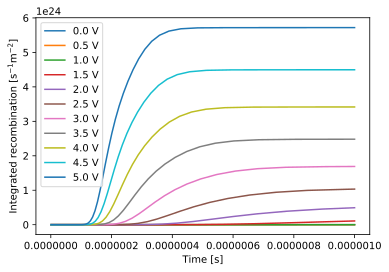

In [10]:
for voltage in progressbar(np.linspace(0,5,11),desc='voltage'):
    params['anode.voltage'] = voltage
    c = context(discrete_model, x=cic.x)
    c.transient(params, 1e-6, 1e-9, reltol=1e-5)
    t, L = c.teval('time', 'outcoupling.L')
    plt.plot(t, L, label='{v} V'.format(v=voltage))
plt.legend(loc='best')
plt.xlabel(r'Time [s]')
plt.ylabel(r'Integrated recombination [$\mathrm{s^{-1} m^{-2}}$]');